In [12]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, exists

In [13]:
def videoReader(video, play=False):
    cap = cv2.VideoCapture(video)
    if (cap.isOpened() == False):
        print("Error opening video stream or file")
    if play:
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == True:
                cv2.imshow('Frame', frame)
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            else:
                break
        cap.release()
        cv2.destroyAllWindows()
    return cap

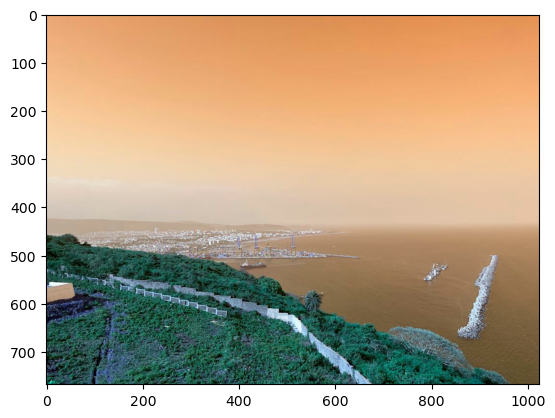

In [14]:
#load and plot the image
imgOG = cv2.imread('../data/images/vizag.jpeg')
# imgOG = cv2.cvtColor(imgOG, cv2.COLOR_BGR2RGB)

#crop the image to half the height (save only top)
# img = imgOG[:imgOG.shape[0]//2, :, :]

plt.imshow(imgOG)
# plt.imshow(img)

In [15]:
def imageHistogram(image):
    nbins = 256
    hist_b = cv2.calcHist([image], [0], None, [nbins], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [nbins], [0, 256])
    hist_r = cv2.calcHist([image], [2], None, [nbins], [0, 256])

    hist_des = np.vstack((hist_r, hist_g, hist_b)).ravel()
    hist_des = hist_des/image.size
    return hist_des

def saveImageHistogram(video_path, sample_frames=100, dir="../data/histograms/"):
    cap = videoReader(video_path)
    numberOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    samplingRate = max(1, numberOfFrames//sample_frames)

    idx = []
    frame_descriptors = []

    for i in range(0, numberOfFrames, samplingRate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        res, frame = cap.read()
        # save only the top half of the image
        frame = frame[:frame.shape[0]//2, :, :]
        idx.append(i)
        frame_descriptors.append(imageHistogram(frame))

    idx = np.array(idx)
    frame_descriptors = np.array(frame_descriptors)
    with open(join(dir, video_path.split("/")[-1].split(".")[0] + ".pickle"), 'wb') as f:
        pickle.dump({'idx': idx, 'descriptors': frame_descriptors},
                    f, protocol=pickle.HIGHEST_PROTOCOL)
        
def loadImageHistogram(video_path, sample_frames=100, dir="../data/histograms/"):
    filename = join(dir, video_path.split(
        "/")[-1].split(".")[0] + ".pickle")
    if not exists(filename):
        saveImageHistogram(video_path, sample_frames, dir)

    with open(filename, 'rb') as f:
        return pickle.load(f)

In [16]:
# saveImageHistogram('../data/videos/dubai.avi')
saveImageHistogram('../data/videos/data/videos_h264/Muckish_24_Hour_Time_Lapse.mp4')

In [17]:
def bestFrame(image, video_path, sample_frames=100):
        '''Search for best frame given a particular video'''
        image_descriptor = imageHistogram(image).reshape((1, -1))

        cap = videoReader(video_path)
        numberOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        samplingRate = max(1, numberOfFrames//sample_frames)

        frame_descriptors = loadImageHistogram(video_path, sample_frames)

        #match the image descriptor with the frame descriptors using MRF and patch match

        #compute the distance between the image descriptor and the frame descriptors
        dist = np.linalg.norm(image_descriptor - frame_descriptors['descriptors'], axis=1)

        #find the index of the frame with the minimum distance
        best_frame_idx = frame_descriptors['idx'][np.argmin(dist)]

        #set the video to the best frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, best_frame_idx)

        #read the frame
        res, frame = cap.read()

        #convert the frame to RGB
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        return frame

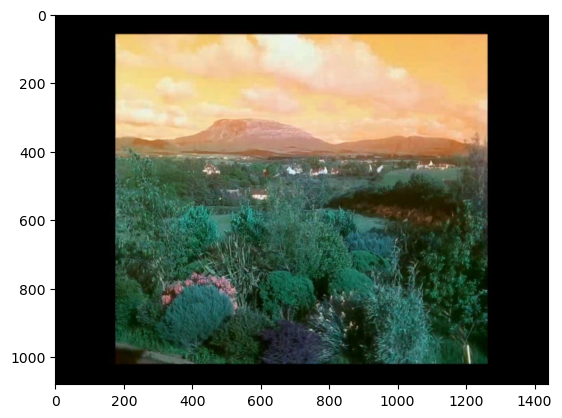

In [18]:
#find the best frame for image 'singapore.jpg' in video 'dubai.avi'
best_frame = bestFrame(imgOG, '../data/videos/data/videos_h264/Muckish_24_Hour_Time_Lapse.mp4')
cv2.imwrite('../data/output/match/muckish_vizag.jpg', best_frame)
plt.imshow(best_frame)